### One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.  

### The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

import seaborn as sns
import pandas_profiling

<Figure size 720x540 with 0 Axes>

In [2]:
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn as sk

In [63]:
data = pd.read_excel('Data Set.xlsx')

In [64]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [66]:
data['Total_spend'] = data['cardspent'] + data['card2spent']

In [67]:
data = data.drop(['cardspent', 'card2spent'], axis=1)
#, 'carditems', 'card2items' not fount on data set

- First: Checking if Total_spend from card is normally distributed 
- i.e.Assumption for regression

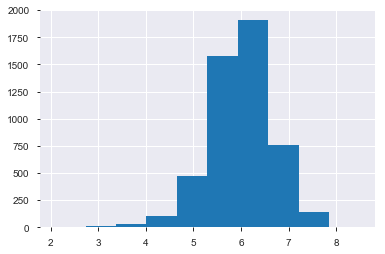

In [68]:
np.log(data.Total_spend).hist()

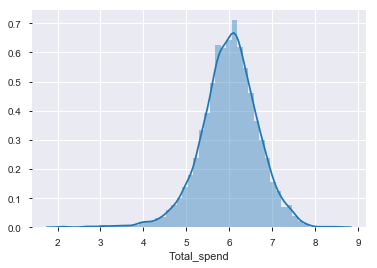

In [69]:
sns.distplot(np.log(data.Total_spend))

In [70]:
data['Log_Total_spend']= np.log(data['Total_spend'])

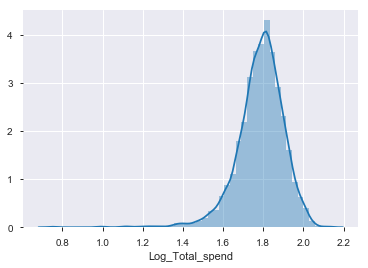

In [71]:
sns.distplot(np.log(data.Log_Total_spend))

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to Log_Total_spend
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [74]:
data = data.drop(['agecat', 'edcat', 'employ', 'lninc', 'lncreddebt',
                  'lnothdebt','spousedcat', 'pets', 'addresscat', 'carcatvalue',
                  'commute', 'commutecat', 'cardtenurecat', 'card2tenurecat', 'lnlongmon',
                  'lnlongten', 'lntollmon', 'lntollten', 'lnequipmon', 'lnequipten', 'lncardmon',
                  'lncardten', 'lnwiremon', 'lnwireten', 'custid'], axis=1)

In [75]:
numeric_var = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64']]
cat_var = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object']]
print(numeric_var)
print('************************************************')
print(cat_var)

['region', 'townsize', 'gender', 'age', 'ed', 'jobcat', 'union', 'empcat', 'retire', 'income', 'inccat', 'debtinc', 'creddebt', 'othdebt', 'default', 'jobsat', 'marital', 'spoused', 'reside', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'homeown', 'hometype', 'address', 'cars', 'carown', 'cartype', 'carvalue', 'carbought', 'carbuy', 'commutetime', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenure', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenure', 'active', 'bfast', 'tenure', 'churn', 'longmon', 'longten', 'tollfree', 'tollmon', 'tollten', 'equip', 'equipmon', 'equipten', 'callcard', 'cardmon', 'cardten', 'wireless', 'wiremon', 'wireten', 'multline', 'voice', 'pager', 'internet', 'callid',

In [76]:
data_num = data[numeric_var]

In [77]:
data_cat = data[cat_var]

In [78]:
#Handaling outliers
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

data_num = data_num.apply(lambda x: outlier_capping(x))

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


In [79]:
data.isnull().any().sum()

4

In [80]:
#Handling missing values
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_num=data_num.apply(lambda x: Missing_imputation(x))

In [81]:
#Handling missings (Categorical)
def Cat_Missing_imputation(x):
    x = x.fillna(x.mode())
    return x

data_cat=data_cat.apply(lambda x: Cat_Missing_imputation(x))

In [82]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

for c_feature in data_cat.columns:
    data_cat[c_feature] = data_cat[c_feature].astype('category')
    data_cat = create_dummies(data_cat , c_feature )

In [83]:
data_cat.head()

,birthmonth_August,birthmonth_December,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


In [84]:
new_data = pd.concat([data_num, data_cat], axis=1)

new_data.head()

,region,townsize,gender,age,ed,jobcat,union,empcat,retire,income,...,birthmonth_December,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September
0,1,2.0,1,20,15,1,1,1,0,31.0,...,0,0,0,0,0,0,0,0,0,1
1,5,5.0,0,22,17,2,0,1,0,15.0,...,0,0,0,0,0,0,1,0,0,0
2,3,4.0,1,67,14,2,0,5,0,35.0,...,0,0,0,0,1,0,0,0,0,0
3,4,3.0,0,23,16,2,0,1,0,20.0,...,0,0,0,0,0,0,1,0,0,0
4,2,2.0,0,26,16,2,0,1,0,23.0,...,0,0,0,1,0,0,0,0,0,0


In [85]:
correlation_metrics=new_data.corr()

correlation_metrics.to_csv('correlation_metrics.csv')

In [86]:
correlation_metrics

,region,townsize,gender,age,ed,jobcat,union,empcat,retire,income,...,birthmonth_December,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September
region,1.000000,0.414026,-0.012810,-0.026525,0.013850,-0.004717,-0.013768,-0.009345,-0.042849,0.036594,...,-0.033034,-0.015546,0.002745,0.020658,0.005281,0.000722,0.021298,-0.012231,-0.011575,0.019683
townsize,0.414026,1.000000,0.009576,-0.075399,0.002968,-0.010768,-0.019846,-0.058059,-0.065779,-0.009478,...,0.019912,-0.024500,-0.008957,0.001582,0.005711,0.002053,-0.000498,-0.019298,0.020539,0.011270
gender,-0.012810,0.009576,1.000000,-0.010186,-0.000777,-0.016470,0.000311,-0.013842,-0.021040,-0.001949,...,-0.016896,0.015168,0.000704,-0.013059,0.007914,0.022453,-0.009947,0.005998,-0.003610,-0.025860
age,-0.026525,-0.075399,-0.010186,1.000000,-0.093966,0.037709,0.011206,0.739573,0.567519,0.208286,...,-0.012816,0.019207,-0.005793,0.020012,0.010682,0.013504,-0.017742,0.008049,-0.029846,-0.012905
ed,0.013850,0.002968,-0.000777,-0.093966,1.000000,-0.072855,0.000273,-0.197841,-0.092627,0.186802,...,-0.007883,-0.021278,0.009659,-0.002186,0.001654,-0.008574,-0.020765,0.016814,0.025154,-0.008178
jobcat,-0.004717,-0.010768,-0.016470,0.037709,-0.072855,1.000000,0.084778,0.346723,0.173736,0.106852,...,0.008243,-0.000695,-0.006297,0.013418,-0.001318,-0.003819,0.017472,-0.030736,-0.005306,0.020834
union,-0.013768,-0.019846,0.000311,0.011206,0.000273,0.084778,1.000000,0.028028,0.016392,0.007588,...,0.032635,-0.010492,0.000998,0.023433,0.009049,-0.015967,-0.010117,0.005503,-0.020332,-0.023708
empcat,-0.009345,-0.058059,-0.013842,0.739573,-0.197841,0.346723,0.028028,1.000000,0.408096,0.375761,...,-0.009242,0.023954,0.005611,0.005418,0.014542,0.028922,-0.012301,-0.006657,-0.035800,-0.007219
retire,-0.042849,-0.065779,-0.021040,0.567519,-0.092627,0.173736,0.016392,0.408096,1.000000,-0.260484,...,-0.001552,-0.005494,0.002049,0.026712,0.002049,-0.006945,-0.005054,-0.016422,-0.001060,0.010554
income,0.036594,-0.009478,-0.001949,0.208286,0.186802,0.106852,0.007588,0.375761,-0.260484,1.000000,...,-0.001010,0.009556,0.004544,-0.008630,0.012303,0.010886,-0.014965,0.017384,-0.013342,-0.023206


In [87]:
# visualize correlation matrix in Seaborn using a heatmap

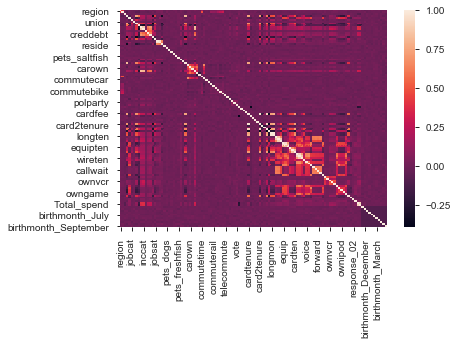

In [88]:
sns.heatmap(new_data.corr())

## Variable Reduction

In [89]:
# Recursive Variables Elimination

In [90]:
features = new_data[new_data.columns.difference( ['Log_Total_spend', 'Total_spend'] )]
target = new_data['Log_Total_spend']

In [91]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import itertools

lm= LinearRegression()

In [92]:
#creating RFE model and selecting 15 variables
REF_MODEL= RFE(lm, n_features_to_select = 15)
REF_MODEL = REF_MODEL.fit(features, target)

In [93]:
REF_MODEL.get_support()

array([False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [94]:
#summarize the selcetion of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(features.columns, REF_MODEL.get_support())]

In [95]:
feature_map


[('active', False),
 ('address', False),
 ('age', False),
 ('bfast', False),
 ('birthmonth_August', False),
 ('birthmonth_December', True),
 ('birthmonth_February', True),
 ('birthmonth_January', False),
 ('birthmonth_July', False),
 ('birthmonth_June', False),
 ('birthmonth_March', False),
 ('birthmonth_May', False),
 ('birthmonth_November', False),
 ('birthmonth_October', False),
 ('birthmonth_September', False),
 ('callcard', False),
 ('callid', False),
 ('callwait', False),
 ('carbought', False),
 ('carbuy', False),
 ('card', True),
 ('card2', True),
 ('card2benefit', False),
 ('card2fee', False),
 ('card2tenure', False),
 ('card2type', False),
 ('cardbenefit', False),
 ('cardfee', False),
 ('cardmon', False),
 ('cardten', False),
 ('cardtenure', False),
 ('cardtype', False),
 ('carown', False),
 ('cars', False),
 ('cartype', False),
 ('carvalue', False),
 ('churn', False),
 ('commutebike', False),
 ('commutebus', False),
 ('commutecar', False),
 ('commutecarpool', False),
 ('commu

In [96]:
#Alternative of capturing the important variables
RFE_features=features.columns[REF_MODEL.get_support()]

In [97]:
feature1 = features[RFE_features]

In [98]:
feature1.head()

,birthmonth_December,birthmonth_February,card,card2,commutenonmotor,default,gender,inccat,owncd,owndvd,owntv,ownvcr,pets_reptiles,response_03,retire
0,0,0,3,5,0,1,1,2,0,1,1,1,0,0,0
1,0,0,2,4,1,1,0,1,1,1,1,1,0,0,0
2,0,0,2,4,0,0,1,2,1,1,1,1,0,0,0
3,0,0,2,3,0,1,0,1,1,1,1,1,0,0,0
4,0,0,4,1,0,0,0,1,1,1,1,1,0,0,0


### F-Regression

In [99]:
#features selection based on importance
from sklearn.feature_selection import f_regression
F_values, p_values = f_regression(feature1, target)

In [100]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(feature1.columns, F_values, ['%.3f' % p for p in p_values])]

In [101]:
f_reg_results = pd.DataFrame(f_reg_results, columns = ['Variable', 'F_value', 'P_value'])

In [102]:
f_reg_results.sort_values(by = ['P_value'])

,Variable,F_value,P_value
2,card,298.331858,0.000
3,card2,29.990236,0.000
6,gender,31.073379,0.000
7,inccat,850.969528,0.000
8,owncd,111.383648,0.000
9,owndvd,138.282716,0.000
10,owntv,36.512224,0.000
11,ownvcr,125.995381,0.000
13,response_03,19.020900,0.000
14,retire,204.476977,0.000


In [103]:
f_reg_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
Variable    15 non-null object
F_value     15 non-null float64
P_value     15 non-null object
dtypes: float64(1), object(2)
memory usage: 440.0+ bytes


### Variance Inflation Factor (VIF)

In [104]:
list_vars = list(f_reg_results.Variable)

In [105]:
all_columns = '+'.join(list_vars)
my_formula = 'Log_Total_spend~'+ all_columns

print(my_formula)

Log_Total_spend~birthmonth_December+birthmonth_February+card+card2+commutenonmotor+default+gender+inccat+owncd+owndvd+owntv+ownvcr+pets_reptiles+response_03+retire


In [106]:
my_formula = 'Log_Total_spend~birthmonth_December+birthmonth_February+card+card2+commutenonmotor+default+gender+inccat+owncd+owndvd+owntv+ownvcr+pets_reptiles+response_03+retire'

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [108]:
from sklearn.model_selection import train_test_split

### Split the data into train & test

In [109]:
train, test = train_test_split(new_data, test_size = 0.3, random_state = 123)

In [110]:
print(len(train))
print('*******')
print(len(test))

3500
*******
1500


In [111]:
# get y and X dataframes based on this regression
y, x = dmatrices(my_formula, train, return_type='dataframe')

#For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['features'] = x.columns

vif.round(1)

,VIF Factor,features
0,92.6,Intercept
1,1.0,birthmonth_December
2,1.0,birthmonth_February
3,1.2,card
4,1.2,card2
5,1.0,commutenonmotor
6,1.1,default
7,1.0,gender
8,1.3,inccat
9,1.5,owncd


## Modeling

In [115]:
import statsmodels.formula.api as smf

In [116]:
#as the vif result shows that is not any such varaibles among these 15 varaibles which needs to br removed therefore
my_formula = 'Log_Total_spend~birthmonth_December+birthmonth_February+card+card2+commutenonmotor+default+gender+inccat+owncd+owndvd+owntv+ownvcr+pets_reptiles+response_03+retire'

In [117]:
model = smf.ols(my_formula, data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Log_Total_spend   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     77.65
Date:                Mon, 26 Aug 2019   Prob (F-statistic):          5.01e-205
Time:                        21:58:12   Log-Likelihood:                -2987.3
No. Observations:                3500   AIC:                             6007.
Df Residuals:                    3484   BIC:                             6105.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.0819    

In [118]:
train['pred'] = pd.DataFrame(np.exp(model.predict(train)))

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
train.head()

,region,townsize,gender,age,ed,jobcat,union,empcat,retire,income,...,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September,pred
4036,5,5.0,1,77,17,5,0,5,1,35.0,...,0,0,0,0,0,0,0,0,1,453.012728
2883,4,1.0,1,76,16,1,0,4,0,48.0,...,0,0,0,0,0,0,0,1,0,381.785794
4162,4,3.0,0,43,17,2,0,3,0,47.0,...,0,1,0,0,0,0,0,0,0,341.327773
4640,2,2.0,0,31,10,6,0,3,0,45.0,...,0,0,0,0,0,0,0,0,0,393.939688
2430,1,1.0,0,35,21,5,0,2,0,37.0,...,0,0,0,0,0,0,0,0,1,370.276875


In [120]:
test['pred'] = pd.DataFrame(np.exp(model.predict(test)))
test.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,region,townsize,gender,age,ed,jobcat,union,empcat,retire,income,...,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September,pred
2648,5,5.0,0,22,17,2,0,1,0,19.0,...,0,0,0,0,0,0,0,0,1,275.623428
2456,5,5.0,1,42,12,1,0,4,0,75.0,...,0,0,0,0,1,0,0,0,0,559.080276
4557,5,1.0,0,70,8,1,1,4,1,12.0,...,0,0,0,0,0,1,0,0,0,371.078702
4884,5,5.0,0,18,13,2,0,1,0,16.0,...,0,0,0,0,0,0,0,0,0,322.538357
92,5,2.0,0,32,14,1,0,2,0,65.0,...,0,1,0,0,0,0,0,0,0,396.373332


In [121]:
# calculate these metrics by hand!
from sklearn import metrics

In [122]:
#for train data
MAPE_train = np.mean(np.abs(train.Total_spend - train.pred)/train.Total_spend)
print('MAPE_train', MAPE_train)

RMSE_train = metrics.mean_squared_error(train.Total_spend, train.pred)
print('MAPE_train', RMSE_train)

RMSPE_train =np.mean(np.square(train.Total_spend - train.pred)/train.Total_spend)
print('RMSPE_train', RMSPE_train)

Corr_train = stats.stats.pearsonr(train.Total_spend, train.pred)
print('Corr_train', Corr_train)

MAPE_train 0.5251248214021311
MAPE_train 82340.94477364601
RMSPE_train 144.56932173716677
Corr_train (0.5270435235703685, 1.6834279017325054e-249)


In [123]:
#for test data
MAPE_test = np.mean(np.abs(test.Total_spend- test.pred)/test.Total_spend)
print('MAPE_test', MAPE_test)

RMSE_test = metrics.mean_squared_error(test.Total_spend, test.pred)
print('RMSE_test', RMSE_test)

RMSPE_test = np.mean(np.square(test.Total_spend - test.pred)/test.Total_spend)
print('RMSPE_test', RMSPE_test)

Corr_test = stats.stats.pearsonr(test.Total_spend, test.pred)
print('Corr_test', Corr_test)

MAPE_test 0.48071973525508194
RMSE_test 81887.72242380078
RMSPE_test 135.03339944235734
Corr_test (0.47281800192287676, 2.140670814609357e-84)


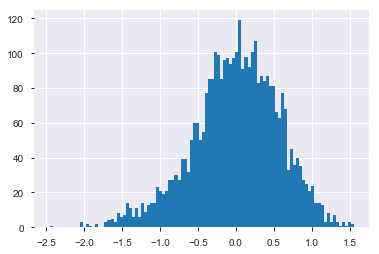

In [124]:
model.resid.hist(bins=100);

In [125]:
#Decile analysis - Train
train['Deciles'] = pd.qcut(train['pred'], 8, labels = False)

avg_actual = train[['Deciles', 'Total_spend']].groupby(train.Deciles).mean().sort_index(ascending=False)['Total_spend']
avg_pred = train[['Deciles', 'pred']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred']

decile_analysis_train = pd.concat([avg_actual, avg_pred], axis=1)
decile_analysis_train

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Total_spend,pred
Deciles,,
7,860.445684,702.316913
6,624.185659,542.952650
5,530.526082,470.288492
4,447.381961,421.529264
3,440.881007,379.340321
2,388.036516,338.199780
1,343.492240,297.977296
0,301.804964,236.546283


In [126]:
#Decile analysis - Test
test['Deciles'] = pd.qcut(test['pred'], 8, labels = False)

avg_actual_test = test[['Deciles', 'Total_spend']].groupby(test.Deciles).mean().sort_index(ascending=False)['Total_spend']
avg_pred_test = test[['Deciles', 'pred']].groupby(test.Deciles).mean().sort_index(ascending=False)['pred']

decile_analysis_test = pd.concat([avg_actual_test, avg_pred_test], axis=1)
decile_analysis_test

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Total_spend,pred
Deciles,,
7,773.701725,698.886891
6,631.292154,547.055721
5,598.084851,481.970672
4,494.695598,430.814099
3,425.292115,386.588738
2,374.377900,344.541471
1,398.265363,303.458477
0,304.242862,239.391518
